# 1) Introduction <a id="1.1"></a>
## Welcome to my NBA Stats Inflation Analysis!
In this notebook I will explore the changes in NBA statistics over the years, compare players across the eras and to find the reasons behind the massive increase in statistics and efficiency in recent years. Enjoy! :)

### 1.2) Notebook setup <a id="1.2"></a>

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [5]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [6]:
player_per_game = pd.read_csv("archive/Player Per Game.csv")
player_per_100_possessions = pd.read_csv("archive/Per 100 Poss.csv")
player_advanced = pd.read_csv("archive/Advanced.csv")
player_totals = pd.read_csv("archive/Player Totals.csv")
player_play_by_play = pd.read_csv("archive/Player Play by Play.csv")
awards = pd.read_csv("archive/Player Award Shares.csv")
foul_data = pd.read_csv("archive/Fouls Data.csv")
team_summaries = pd.read_csv("archive/Team Summaries.csv")
team_per_game = pd.read_csv("archive/Team Stats Per Game.csv")
team_per_100_possessions = pd.read_csv("archive/Team Stats Per 100 Poss.csv")

### 1.3) Data preparation <a id="1.3"></a>
Here, I'm upgrading the player_per_game dataframe since when I was first exploring the data I noticed that some players had multiple rows for the same season, which later led to misleading statistics.

In [7]:
grouped_players = player_totals.groupby(["player_id", 'season'])

def filter_players(group):
    if len(group) > 1:
        tot_group = group[group['tm'] == 'TOT']
        if not tot_group.empty:
            return tot_group  
    return group

player_totals = grouped_players.apply(filter_players).reset_index(drop=True)

stats = ['mp', 'fg', 'fga','x3p', 'x3pa', 'x2p', 'x2pa', 'ft', 'fta' , 'orb', 'drb', 'trb', 'ast','stl', 'blk', 'tov', 'pf', 'pts']

player_totals.loc[:, stats] = player_totals[stats].div(player_totals["g"], axis=0).round(1)

player_better_per_game = player_totals

columns_to_rename = ['mp', 'fg', 'fga', 'fg_percent','x3p', 'x3pa', 'x3p_percent', 'x2p', 'x2pa', 'x2p_percent','e_fg_percent', 'ft', 'fta', 'ft_percent', 'orb', 'drb', 'trb', 'ast','stl', 'blk', 'tov', 'pf', 'pts']

player_better_per_game.rename(columns=lambda x: x + "_per_game" if x in columns_to_rename else x, inplace=True)


Here I made a player_better_stats dataframe which contains the proper per game stats and advanced stats with added relative true shooting percentage and points per 75 possessions (which is a better metric to compare players across the eras). I also fixed the positions of the players, so that they are more readable.

In [8]:
player_better_stats = pd.merge(player_better_per_game, team_summaries[['season', 'abbreviation', 'pace']], how="left", left_on=["season", "tm"], right_on=["season", "abbreviation"])

player_better_stats = pd.merge(player_better_stats, player_advanced, how="left", left_on=["season", "tm", "player"], right_on=["season", "tm", "player"])

avg_ts_percent = team_summaries.groupby("season")["ts_percent"].mean().round(3) * 100
avg_ts_percent = avg_ts_percent.reset_index()

player_better_stats = pd.merge(player_better_stats, avg_ts_percent, on="season", suffixes=("", "_league_avg"))

player_better_stats['ts_percent'] = player_better_stats['ts_percent'] * 100

player_better_stats["relative_ts"] = player_better_stats['ts_percent'] - player_better_stats["ts_percent_league_avg"]

player_better_stats.drop(columns=[col for col in player_better_stats.columns if col.endswith("_y")], inplace=True)

player_better_stats.rename(columns=lambda x: x[:-2] if x.endswith("_x") else x, inplace=True)

player_better_stats["pts_per_75"] = (player_better_stats['pts_per_game'] / ((player_better_stats["mp_per_game"] * player_better_stats["pace"]) / 48) * 75).round(1)

player_better_stats = player_better_stats.query("g >= 25")

player_better_stats["pos"] = player_better_stats["pos"].apply(lambda x: x.split("-")[0])
player_better_stats["pos"] = player_better_stats["pos"].apply(lambda x: "SF" if x == "F" else x)
player_better_stats["pos"] = player_better_stats["pos"].apply(lambda x: "SG" if x == "G" else x)

## 2) Stats changing over the years. <a id="2"></a>
If you are NBA fan like me, you probably hear phrases like "The game has changed", "Players are not the same as they used to be", "This is not basketball", all the time from older fans. I started following NBA in 2014-2015 season when Stephen Curry and the Golden State Warriors were taking the league by storm, so I have lived through the revolution. However, I have always been interested in the history of the game and how it has evolved over the years. In this section I will explore how the statistics have changed over the years.

### 2.1) Number of elite scorers in each season <a id="2.1"></a>

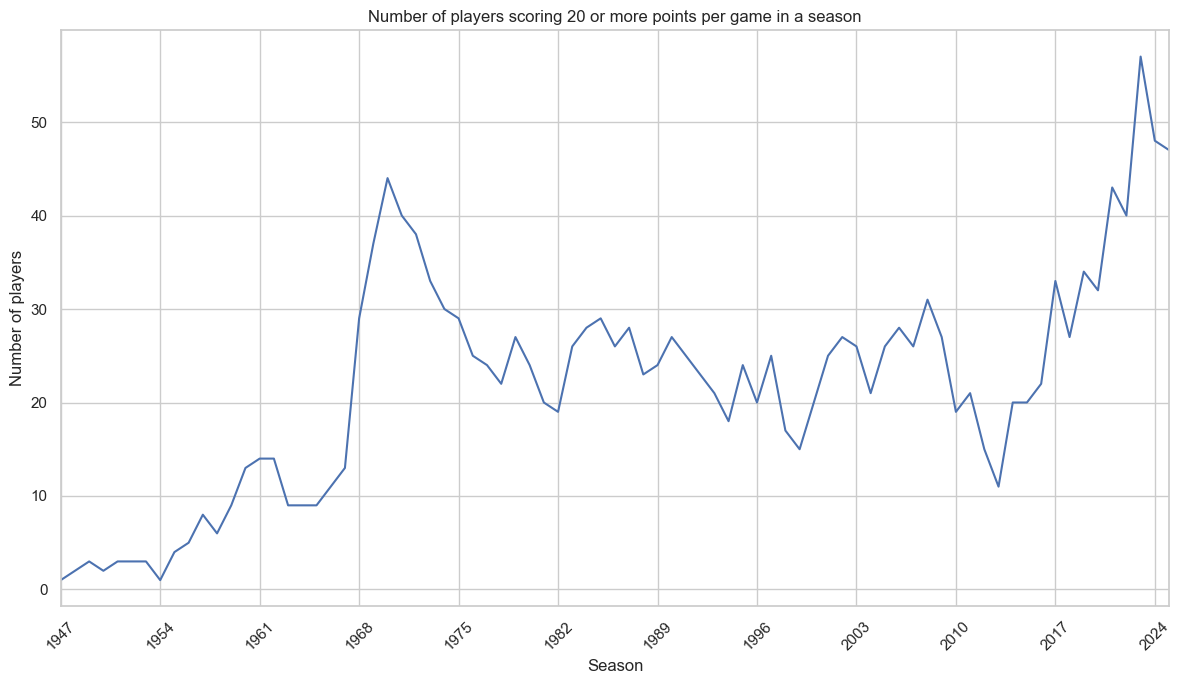

In [9]:
number_of_players_20pts = player_better_stats[player_better_stats["pts_per_game"] >= 20].groupby("season").size()

sns.set_theme(style="whitegrid")
palette = sns.color_palette("mako", n_colors=2)

plt.figure(figsize=(12,7))
sns.lineplot(number_of_players_20pts)
plt.title("Number of players scoring 20 or more points per game in a season")
plt.xlabel("Season")
plt.ylabel("Number of players")
plt.xlim(player_per_game["season"].min(), player_per_game["season"].max())
plt.xticks(range(player_per_game["season"].min(), player_per_game["season"].max() + 1, 7) ,rotation=45)
plt.tight_layout()
plt.show()

As we can see, number of players scoring 20 or more points has skyrocketed in the last 10 years. Later in the notebook we will discuss what factors may cause this rapid growth.

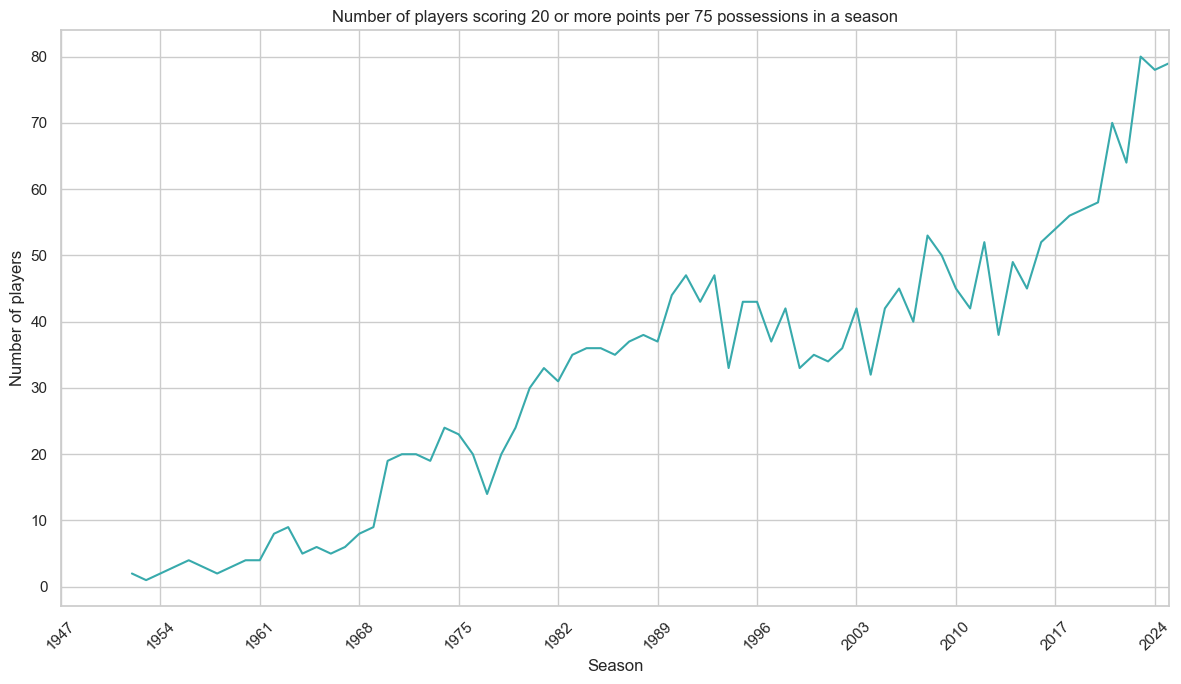

In [10]:
number_of_players_20pts_75 = player_better_stats[player_better_stats["pts_per_75"] >= 20].groupby("season").size()

sns.set_theme(style="whitegrid")
palette = sns.color_palette("mako", n_colors=2)

plt.figure(figsize=(12,7))
sns.lineplot(number_of_players_20pts_75, color=palette[1])
plt.title("Number of players scoring 20 or more points per 75 possessions in a season")
plt.xlabel("Season")
plt.ylabel("Number of players")
plt.xlim(player_per_game["season"].min(), player_per_game["season"].max())
plt.xticks(range(player_per_game["season"].min(), player_per_game["season"].max() + 1, 7) ,rotation=45)
plt.tight_layout()
plt.show()

When we look at the same graph but adjusting the stats to per 75 possessions, we see that the number of elite scorers has an even more upward trend. 

### 2.2) Points per game and number of possesions (pace) <a id="2.2"></a>

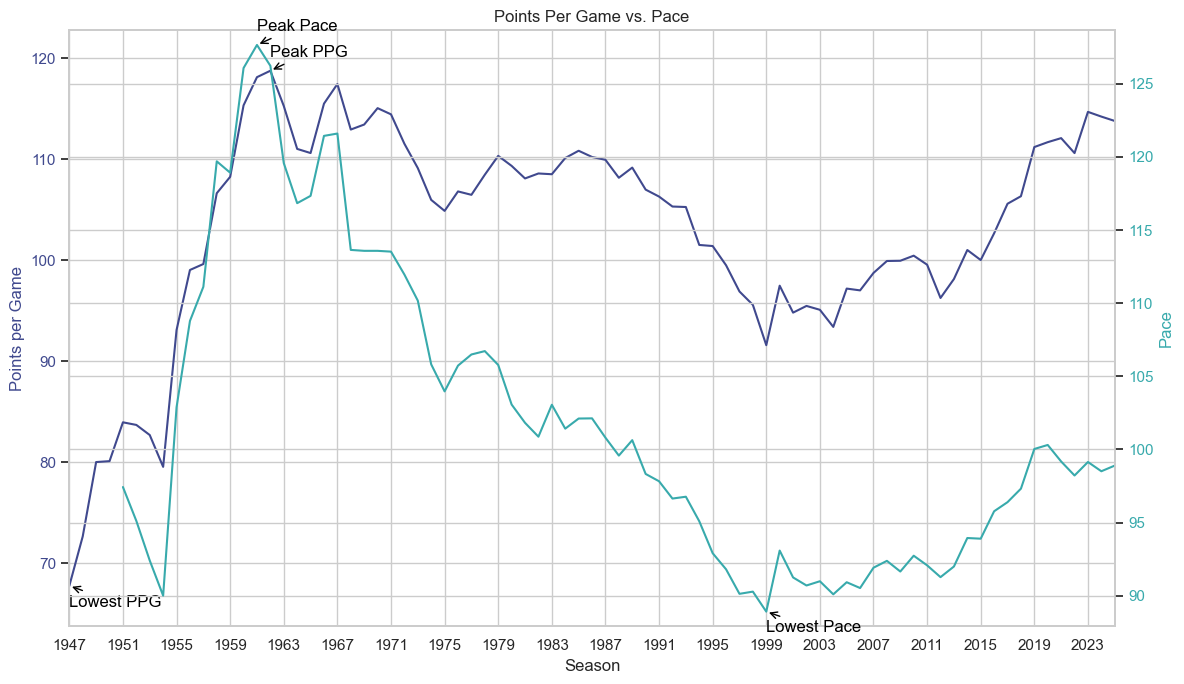

In [11]:
points_per_game_season = team_per_game.groupby("season")["pts_per_game"].mean()
pace_season = team_summaries.groupby("season")["pace"].mean()

sns.set_theme(style="whitegrid")
palette = sns.color_palette("mako", n_colors=2)

fig, ax1 = plt.subplots(figsize=(12, 7))

color = palette[0]
sns.lineplot(data=points_per_game_season, ax=ax1, color=color)
ax1.set_xlabel('Season')
ax1.set_ylabel('Points per Game', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(points_per_game_season.min() - 4, points_per_game_season.max() + 4)  

max_ppg = points_per_game_season.idxmax()
min_ppg = points_per_game_season.idxmin()
ax1.annotate('Peak PPG', xy=(max_ppg, points_per_game_season[max_ppg]), xytext=(0, 10),
             textcoords="offset points", arrowprops=dict(arrowstyle="->", color="black"), color="black")
ax1.annotate('Lowest PPG', xy=(min_ppg, points_per_game_season[min_ppg]), xytext=(0, -15),
             textcoords="offset points", arrowprops=dict(arrowstyle="->", color="black"), color="black")

ax2 = ax1.twinx()
color = palette[1]
sns.lineplot(data=pace_season, ax=ax2, color=color)
ax2.set_ylabel('Pace', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(pace_season.min() - 1, pace_season.max() + 1)  

max_pace = pace_season.idxmax()
min_pace = pace_season.idxmin()
ax2.annotate('Peak Pace', xy=(max_pace, pace_season[max_pace]), xytext=(0, 10),
             textcoords="offset points", arrowprops=dict(arrowstyle="->", color="black"), color="black")
ax2.annotate('Lowest Pace', xy=(min_pace, pace_season[min_pace]), xytext=(0, -15),
             textcoords="offset points", arrowprops=dict(arrowstyle="->", color="black"), color="black")

ax1.set_xlim(team_per_game["season"].min(), team_per_game["season"].max())
ax1.set_xticks(range(team_per_game["season"].min(), team_per_game["season"].max() + 1, 4))

plt.title('Points Per Game vs. Pace')
fig.tight_layout()

plt.show()

Points per game by a team is also on a rise in the last 10 years, nearly matching the values of the 60s where the pace peaked.

### 2.3) Efficiency of NBA offenses <a id="2.3"></a>

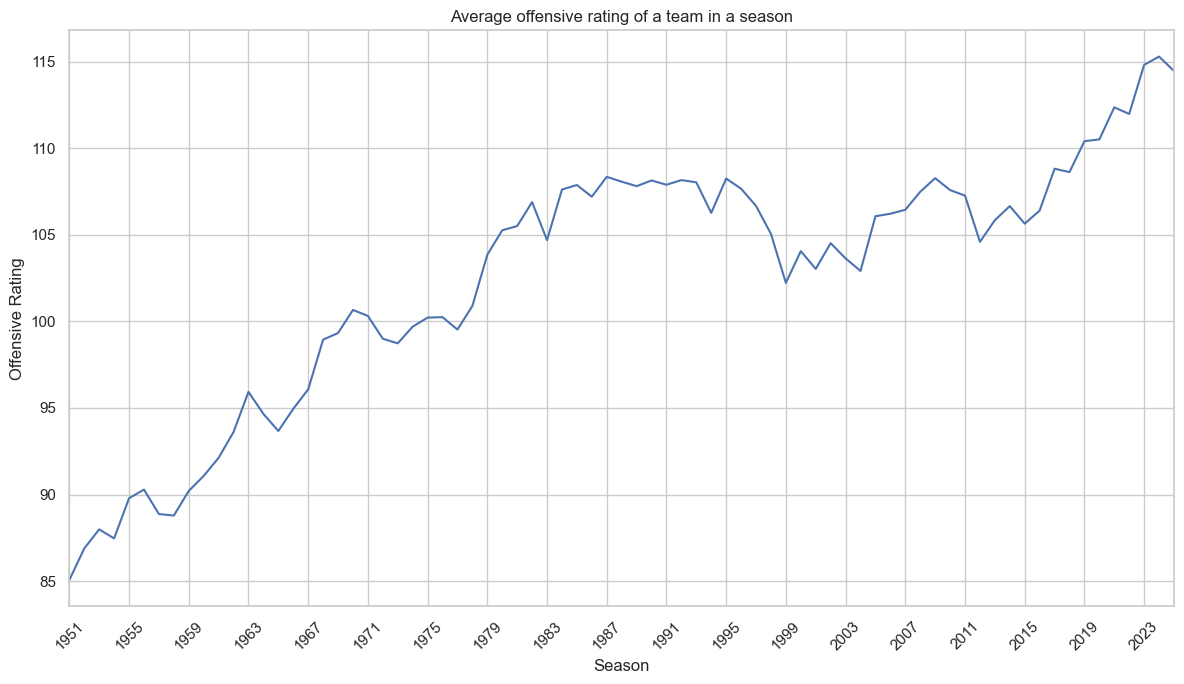

In [12]:
ortg = team_summaries.groupby("season")["o_rtg"].mean()

sns.set_theme(style="whitegrid")
palette = sns.color_palette("mako", n_colors=2)

plt.figure(figsize=(12,7))
sns.lineplot(ortg)
plt.title("Average offensive rating of a team in a season")
plt.xlabel("Season")
plt.ylabel("Offensive Rating")
plt.xlim(team_summaries[team_summaries["o_rtg"].notnull()]["season"].min(), team_summaries["season"].max())
plt.xticks(range(team_summaries[team_summaries["o_rtg"].notnull()]["season"].min(),team_summaries["season"].max(), 4 ), rotation=45)
plt.tight_layout()
plt.show()

When we look at offensive rating through the years we see how efficient the NBA years have gotten in the last 10 years, which explains how they can match the number of points scored in a game, while having less possessions. We see that the teams in the 60s and 70s weren't really efficient despite the game scores being so high.

## 3) Comparing players across the eras <a id="3"></a>
Were NBA players in the older days really better that modern players, or were they playing against different rules, different competition and overall a different basketball. It's difficult to compare players from other eras, since there are so many variables acting on their statistics. Here I will try my best to make an even playing field for everyone.

### 3.1) How points per game lie <a id="3.1"></a>

In [13]:
player_per_game.sort_values("pts_per_game", ascending=False).head(15)[["tm", "season", "player", "pts_per_game"]]

,tm,season,player,pts_per_game
30267,PHW,1962,Wilt Chamberlain,50.4
30133,SFW,1963,Wilt Chamberlain,44.8
29867,SFW,1965,Wilt Chamberlain,38.9
30375,PHW,1961,Wilt Chamberlain,38.4
30188,LAL,1962,Elgin Baylor,38.3
30498,PHW,1960,Wilt Chamberlain,37.6
21907,CHI,1987,Michael Jordan,37.1
30003,SFW,1964,Wilt Chamberlain,36.9
4591,HOU,2019,James Harden,36.1
29578,SFW,1967,Rick Barry,35.6


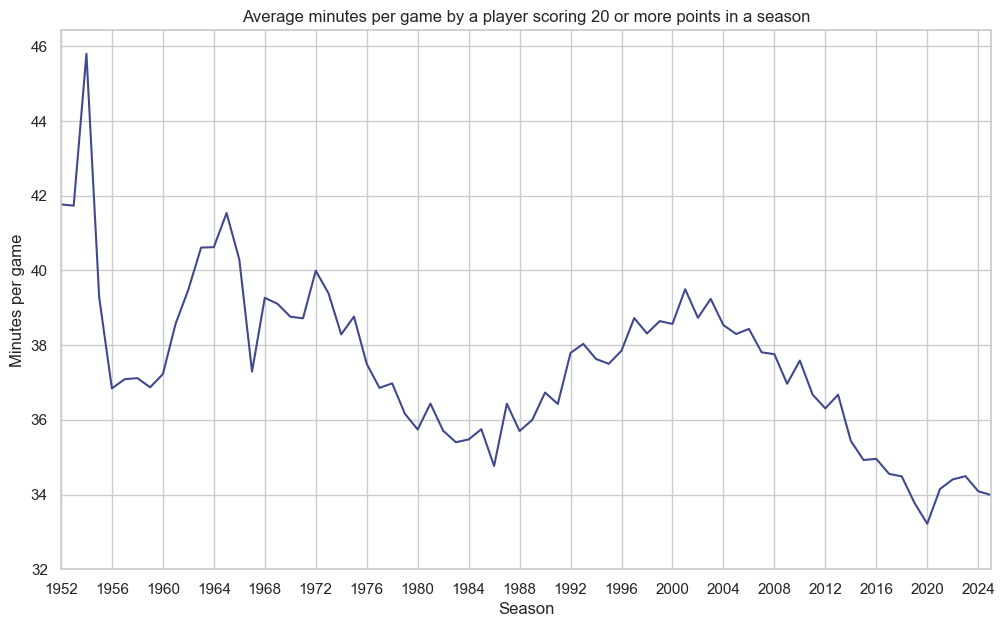

In [14]:
mp_by_stars = player_per_game[player_per_game["pts_per_game"] >= 20].groupby("season")["mp_per_game"].mean()

sns.set_theme(style="whitegrid")
palette = sns.color_palette("mako", n_colors=2)

fig, ax = plt.subplots(figsize=(12,7))
sns.lineplot(mp_by_stars, color=palette[0])
ax.set_title("Average minutes per game by a player scoring 20 or more points in a season")
ax.set_xlabel("Season")
ax.set_ylabel("Minutes per game")
ax.set_xlim(player_per_game[player_per_game["mp_per_game"].notnull()]["season"].min(), player_per_game["season"].max())
ax.set_xticks(range(player_per_game[player_per_game["mp_per_game"].notnull()]["season"].min(), player_per_game["season"].max() + 1, 4))
ax.set_yticks(range(32, 48, 2))

plt.show()

When we look at the top 15 scoring seasons of all time, we see that 10 of them are from the 60s and 70s. Wilt Chamberlain's 1961-1962 season where he averaged 50.4 looks unreal. However, when we consider the much faster pace of the game back then and the ammount of minutes those players played, it is easy to see why the numbers are so high. Let's adjust the statistics a little to make it a even playing field for everyone.

In [15]:
player_better_stats.sort_values("pts_per_75", ascending=False)[["tm", 'season', 'player', "pts_per_75", 'pts_per_game', 'ts_percent', 'relative_ts']].head(15)

,tm,season,player,pts_per_75,pts_per_game,ts_percent,relative_ts
25413,PHI,2024,Joel Embiid,38.1,34.7,64.4,6.4
22623,HOU,2019,James Harden,36.1,36.1,61.6,5.6
24902,PHI,2023,Joel Embiid,35.5,33.1,65.5,7.4
8849,CHI,1987,Michael Jordan,34.9,37.1,56.2,2.4
24818,MIL,2023,Giannis Antetokounmpo,34.7,31.1,60.5,2.4
26031,OKC,2025,Shai Gilgeous-Alexander,34.6,32.8,64.1,6.5
16935,LAL,2006,Kobe Bryant,34.2,35.4,55.9,2.3
23801,PHI,2022,Joel Embiid,33.9,30.6,61.6,5.0
21642,OKC,2017,Russell Westbrook,33.6,31.6,55.4,0.2
24985,DAL,2023,Luka Dončić,33.4,32.4,60.9,2.8


A star NBA player plays around 75 possessions per game. When we adjust the stats to per 75 possesions, we see that out of 15 best scoring seasons according to this metric, only 3 of them didn't happen in recent years. The best scoring season belongs to Joel Embiid, however he only played 39 games this season, so we can't be sure if he would keep up the pace for the whole season. If we exclude Embiid's 2023-2024's season, the best scoring seasons belongs to James Harden in 2018-2019 where he averaged 36.1 points pers 75.

In [16]:
player_better_stats.query("player == 'Wilt Chamberlain' and season == 1962")[["tm", 'season', 'player', "pts_per_75", 'pts_per_game', 'ts_percent', 'relative_ts']]

,tm,season,player,pts_per_75,pts_per_game,ts_percent,relative_ts
1879,PHW,1962,Wilt Chamberlain,28.5,50.4,53.6,5.7


If we look at Wilt's numbers now, we see that they are still great, but not as good as we would think.

### 3.2) Searching for the best scoring season of all time

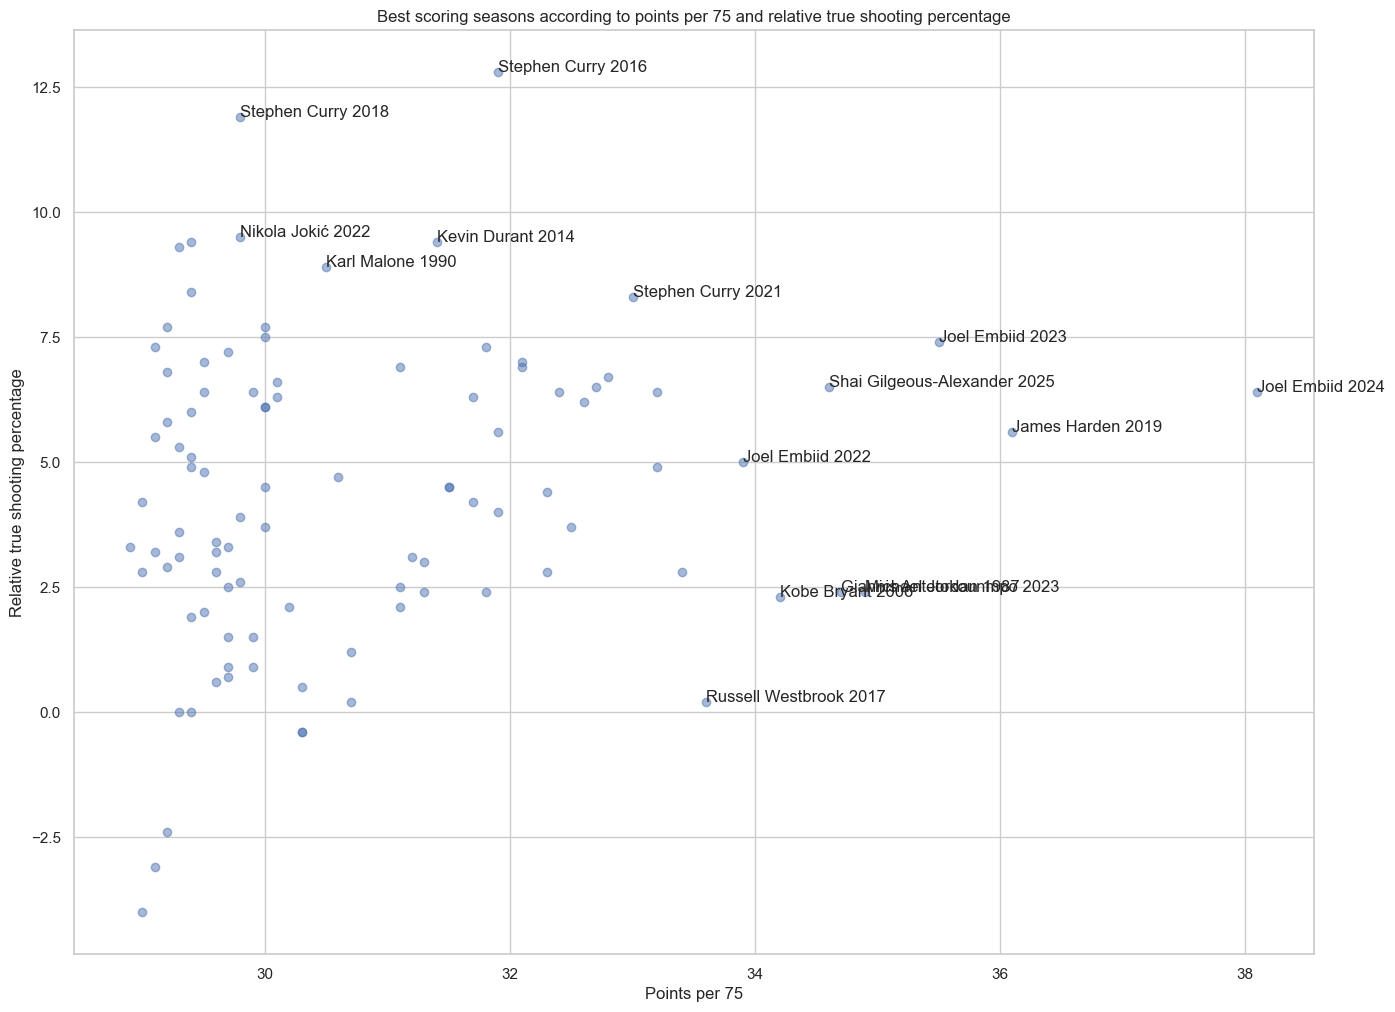

In [17]:
plt.figure(figsize=(16,12))
plt.scatter(x="pts_per_75", y="relative_ts", data=player_better_stats.sort_values("pts_per_75", ascending=False).head(100), alpha=0.5)

filtered_data = player_better_stats.query("(pts_per_75 >= 33.5) or (pts_per_75 >= 29.5 and relative_ts >= 8)")

for i in range(filtered_data.shape[0]):
    plt.text(x=filtered_data.iloc[i]["pts_per_75"], y=filtered_data.iloc[i]["relative_ts"], s=filtered_data.iloc[i]["player"] + " " + str(filtered_data.iloc[i]["season"]))

plt.title("Best scoring seasons according to points per 75 and relative true shooting percentage")
plt.xlabel("Points per 75")
plt.ylabel("Relative true shooting percentage")
plt.show()

Here's a look at best scoring seasons according to points per 75 and relative true shooting percentage. To consider which season is the best we have to think what we value more, more scoring or more efficiency. If we look at Curry in 2016 we see that he led the league in both points per 75 and efficiency, which is why many consider his 2016 season as the best scoring season of all-time. On the other hand we have Harden in 2019 who scored 36.1 points per 75, which ranks number 1 all-time in volume, his efficiency was still good, but not as mind-blowing as Curry's in 2016. 

In [18]:
player_better_stats.query("season == 2016").sort_values("ts_percent", ascending=False)[["tm", 'season', 'player', "pts_per_75", 'pts_per_game', 'ts_percent', 'relative_ts']]

,tm,season,player,pts_per_75,pts_per_game,ts_percent,relative_ts
21219,GSW,2016,Stephen Curry,31.9,30.1,66.9,12.8
21448,SAS,2016,Boban Marjanović,22.5,5.5,66.2,12.1
21098,SAS,2016,Matt Bonner,13.9,2.5,64.7,10.6
21422,TOR,2016,Lucas Nogueira,10.9,2.2,64.2,10.1
21137,TOT,2016,Ryan Hollins,NaN,3.4,63.6,9.5
...,...,...,...,...,...,...,...
21407,BOS,2016,James Young,5.3,1.0,38.4,-15.7
21062,WAS,2016,Drew Gooden,9.7,2.7,37.6,-16.5
21393,ORL,2016,Devyn Marble,8.8,2.1,36.8,-17.3
21496,POR,2016,Pat Connaughton,9.8,1.1,35.2,-18.9


In [19]:
player_better_stats.query("season == 2016").sort_values("pts_per_75", ascending=False)[["tm", 'season', 'player', "pts_per_75", 'pts_per_game', 'ts_percent', 'relative_ts']]

,tm,season,player,pts_per_75,pts_per_game,ts_percent,relative_ts
21219,GSW,2016,Stephen Curry,31.9,30.1,66.9,12.8
21154,OKC,2016,Kevin Durant,29.3,28.2,63.4,9.3
21207,HOU,2016,James Harden,28.1,29.0,59.8,5.7
21231,SAC,2016,DeMarcus Cousins,28.0,26.9,53.8,-0.3
21079,CLE,2016,LeBron James,27.4,25.3,58.8,4.7
...,...,...,...,...,...,...,...
21365,TOT,2016,Ray McCallum,NaN,3.3,44.9,-9.2
21402,TOT,2016,JaKarr Sampson,NaN,5.1,50.4,-3.7
21430,TOT,2016,P.J. Hairston,NaN,6.2,47.0,-7.1
21433,TOT,2016,Sean Kilpatrick,NaN,11.1,57.6,3.5


### 3.3) Exploring players who might have played aheaf of their times

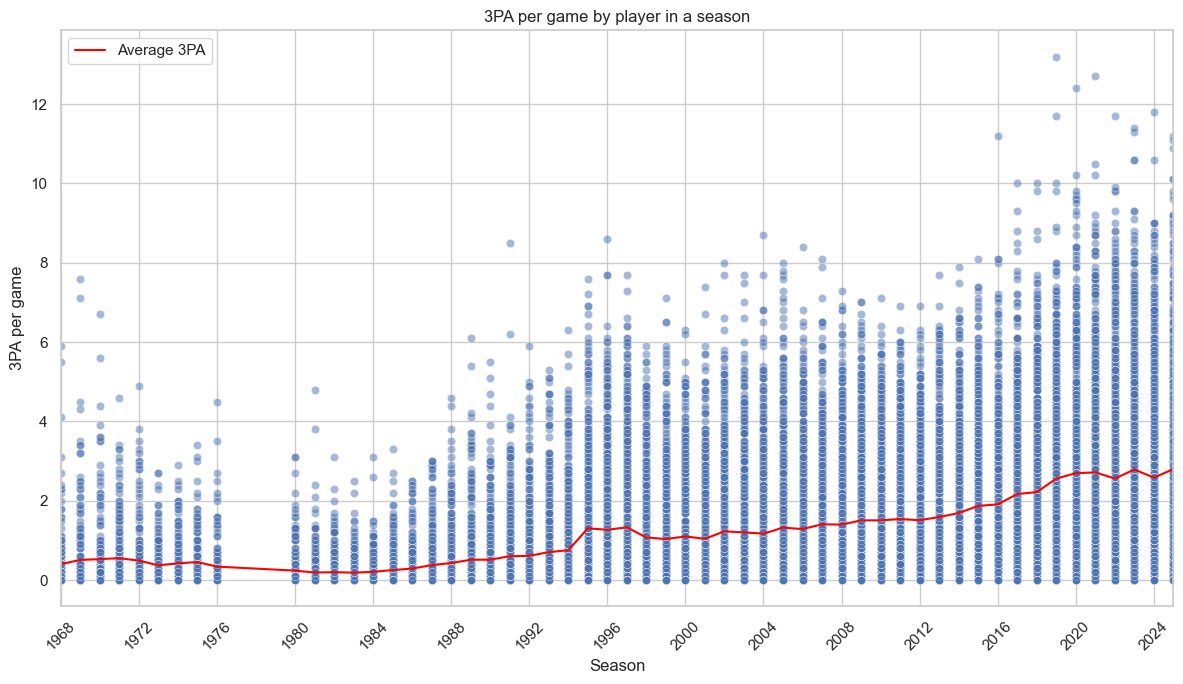

In [20]:
plt.figure(figsize=(12,7))
sns.lineplot(player_per_game.groupby("season")["x3pa_per_game"].mean(), label="Average 3PA", color="red")
plt.legend(loc="upper left")
sns.scatterplot(x="season", y="x3pa_per_game", data=player_per_game, alpha=0.5)
plt.title("3PA per game by player in a season")
plt.xlabel("Season")
plt.ylabel("3PA per game")

plt.xlim(1968, player_per_game["season"].max())
plt.xticks(range(1968, player_per_game["season"].max() + 1, 4), rotation=45)

plt.tight_layout()
plt.show()

In [21]:
player_better_stats.query("x3pa_per_game >= 5 and season <= 1976")[["season", "player", "x3pa_per_game", "x3p_percent_per_game"]].sort_values("x3pa_per_game", ascending=False)

,season,player,x3pa_per_game,x3p_percent_per_game
3181,1969,Chico Vaughn,7.6,0.277
3329,1969,Louie Dampier,7.1,0.361
2323,1970,Louie Dampier,6.7,0.361
2971,1968,Lester Selvage,5.9,0.319
2764,1968,Chico Vaughn,5.5,0.334


We see that when the ABA introduced the 3 point line in 1967 some players actually took couple three pointers per game with Louie Dampier leading the way with both high volume and efficiency compared to the other players. All of those seasons came in the first three years of introducing the three poit line, which shows that as the years went by the 3 pointer was shot less and less until it disappeared for 3 years. 

In [22]:
player_better_stats.query("x3pa_per_game >= 4 and 1980 <= season < 1990")[["season", "player", "x3pa_per_game", "x3p_percent_per_game"]].sort_values("x3pa_per_game", ascending=False)

,season,player,x3pa_per_game,x3p_percent_per_game
9491,1989,Michael Adams,6.1,0.356
9187,1988,Michael Adams,4.6,0.367
9051,1988,Danny Ainge,4.4,0.415
9367,1989,Danny Ainge,4.2,0.380
9421,1989,Dale Ellis,4.1,0.478


In the 80s players were even more reluctant to shooting the 3, with only 5 players taking 4 or more threes per game in a season. Both of those seasons happened near the end of a decade which display the opposite trend to the 60s and 70s.

In [23]:
player_better_stats.query("player == 'Larry Bird'")[["season", "player", "x3pa_per_game", "x3p_percent_per_game"]].sort_values("season")

,season,player,x3pa_per_game,x3p_percent_per_game
6720,1980,Larry Bird,1.7,0.406
6954,1981,Larry Bird,0.9,0.270
7233,1982,Larry Bird,0.7,0.212
7513,1983,Larry Bird,1.0,0.286
7801,1984,Larry Bird,0.9,0.247
8090,1985,Larry Bird,1.6,0.427
8393,1986,Larry Bird,2.4,0.423
8697,1987,Larry Bird,3.0,0.400
9017,1988,Larry Bird,3.1,0.414
9687,1990,Larry Bird,2.6,0.333


Larry Bird won 3 three point contests in the 80s, but he actually never attempted more than 3.5 threes per game in a season. However, he was quite efficient from the 3 point line, shooting 40% or better in 6 of his 13 seasons.

In [24]:
player_better_stats.query("x3pa_per_game >= 7 and 1990 <= season < 2000")[["season", "player", "x3pa_per_game", "x3p_percent_per_game"]].sort_values("x3pa_per_game", ascending=False)

,season,player,x3pa_per_game,x3p_percent_per_game
12150,1996,George McCloud,8.6,0.379
10184,1991,Michael Adams,8.5,0.296
12156,1996,Mookie Blaylock,7.7,0.371
12179,1996,Dennis Scott,7.7,0.425
12567,1997,Mookie Blaylock,7.7,0.366
11737,1995,John Starks,7.6,0.355
12576,1997,Tim Hardaway,7.3,0.344
11786,1995,Tim Hardaway,7.2,0.378
13419,1999,Dee Brown,7.1,0.387


In [25]:
player_better_stats.query("x3pa_per_game >= 8.5 and season == 2024")[["season", "player", "x3pa_per_game", "x3p_percent_per_game"]].sort_values("x3pa_per_game", ascending=False)

,season,player,x3pa_per_game,x3p_percent_per_game
25306,2024,Stephen Curry,11.8,0.408
25485,2024,Luka Dončić,10.6,0.382
25318,2024,Klay Thompson,9.0,0.387
25431,2024,Donovan Mitchell,9.0,0.368
25457,2024,Anfernee Simons,8.8,0.385
25464,2024,Donte DiVincenzo,8.7,0.401
25496,2024,Trae Young,8.7,0.373
25561,2024,Desmond Bane,8.6,0.381
25329,2024,Damian Lillard,8.5,0.354


In the 90s we saw an increase in three point shooting especially after the league shorten the distance of the three pointer. The true outlier here is Micheal Adams, who in 1991 attempted 8.5 threes per game, which today would rank him number 11 in the league in three point attempts, while the other seasons came in the shortened three point line period. However, Adams's efficiency was very low, in today's game he would be ignored by the defenses on the perimeter, as he shot only 29.6% from the three. 

In [26]:
player_better_stats.query("player == 'Reggie Miller'")[["season", "player", "x3pa_per_game", "x3p_percent_per_game"]].sort_values("season")

,season,player,x3pa_per_game,x3p_percent_per_game
9285,1988,Reggie Miller,2.1,0.355
9571,1989,Reggie Miller,3.3,0.402
9900,1990,Reggie Miller,4.4,0.414
10245,1991,Reggie Miller,3.9,0.348
10600,1992,Reggie Miller,4.2,0.378
10961,1993,Reggie Miller,5.1,0.399
11324,1994,Reggie Miller,3.7,0.421
11712,1995,Reggie Miller,5.8,0.415
12099,1996,Reggie Miller,5.4,0.410
12519,1997,Reggie Miller,6.6,0.427


Let's look at Reggie Miller who by many is considered one of the greatest shooters of all time. He actually didn't attempt that many three pointers in his career, with peak in 1997 season when he attempted 6.6 three pointers per game. Though he was very efficient from the three point line, shooting 40% or better in 9 of his 18 seasons. Reggie is also considered to play ahead of his time, as he was one of the first players to utilize off ball movement to get open three point shots.

In [27]:
player_better_stats.query("x3pa_per_game >= 7 and 2000 <= season < 2010")[["season", "player", "x3pa_per_game", "x3p_percent_per_game"]].sort_values("x3pa_per_game", ascending=False)

,season,player,x3pa_per_game,x3p_percent_per_game
15715,2004,Baron Davis,8.7,0.321
16942,2006,Ray Allen,8.4,0.412
16467,2007,Ray Allen,8.1,0.372
14812,2002,Antoine Walker,8.0,0.344
16191,2005,Quentin Richardson,8.0,0.358
16586,2007,Gilbert Arenas,7.9,0.351
14833,2002,Ray Allen,7.7,0.434
15672,2004,Tracy McGrady,7.7,0.339
16128,2005,Baron Davis,7.7,0.333
15211,2003,Antoine Walker,7.5,0.323


In the 2000s we saw a significant increase in three point shooting as 20 players attempted 7 or more three pointers per game in a season. Leading the way was Ray Allen with 6 seasons in the 2000s with atleast 7 three point attempts per game. Ray Allen was also quite efficient from the three point line. That is way he is considered one of the greatest shooters of all time.

In [28]:
player_better_stats.query("player == 'Steve Nash'").sort_values("season")[["season", "player", "x3pa_per_game", "x3p_percent_per_game"]]

,season,player,x3pa_per_game,x3p_percent_per_game
12873,1997,Steve Nash,0.8,0.418
13247,1998,Steve Nash,2.6,0.415
13635,1999,Steve Nash,3.3,0.374
14044,2000,Steve Nash,2.7,0.403
14445,2001,Steve Nash,3.1,0.406
14839,2002,Steve Nash,4.2,0.455
15236,2003,Steve Nash,3.3,0.413
15643,2004,Steve Nash,3.3,0.405
16060,2005,Steve Nash,2.9,0.431
16947,2006,Steve Nash,4.3,0.439


Let's look at Steve Nash who is also considered as one of the best shooters of all time, as well as someone who would thrive in today's nba. He didn't attempt that many three pointers in his career, due to being a pass first point guard, but he was very efficient from the three point line, shooting 40% or better in 10 of his 18 seasons.

In [29]:
player_better_stats.query("x3pa_per_game >= 7 and 2010 <= season < 2020").sort_values("x3pa_per_game", ascending=False)[["season", "player", "x3pa_per_game", "x3p_percent_per_game"]]

,season,player,x3pa_per_game,x3p_percent_per_game
22623,2019,James Harden,13.2,0.368
22632,2019,Stephen Curry,11.7,0.437
21219,2016,Stephen Curry,11.2,0.454
22108,2018,James Harden,10.0,0.367
21665,2017,Stephen Curry,10.0,0.411
22654,2019,Paul George,9.8,0.386
22117,2018,Stephen Curry,9.8,0.423
21653,2017,James Harden,9.3,0.347
22670,2019,Kemba Walker,8.9,0.356
21628,2017,Eric Gordon,8.8,0.372


In the second half of the 2010s we saw a massive boom in three point shooting mostly because of Stephen Curry and the Golden State Warriors, with 63 players attempting 7 or more three pointers per game in a season.

In [30]:
player_better_stats.query("x3pa_per_game >= 7 and season > 2020").sort_values("x3pa_per_game", ascending=False)[["season", "player", "x3pa_per_game", "x3p_percent_per_game"]]

,season,player,x3pa_per_game,x3p_percent_per_game
24252,2021,Stephen Curry,12.7,0.421
25306,2024,Stephen Curry,11.8,0.408
23644,2022,Stephen Curry,11.7,0.380
24775,2023,Stephen Curry,11.4,0.427
24801,2023,Damian Lillard,11.3,0.371
...,...,...,...,...
23752,2022,Devin Booker,7.0,0.383
25040,2023,Max Strus,7.0,0.350
23642,2022,Patty Mills,7.0,0.400
24279,2021,Kyrie Irving,7.0,0.402


In 2020s it became even more absurd, with 127 players shooting attempting 7 or more threes per game, which is more than twice as much as in the entire 2010s.

# 4) What causes the inflation? <a id="4"></a>
There has been many changes in the NBA over the years that may have caused the statistical boom. Some of them clearly stated, while others are more subtle and harder to notice. Let's explore some of those factors.

### 4.1) Introduction of the shot clock <a id="4.1"></a>

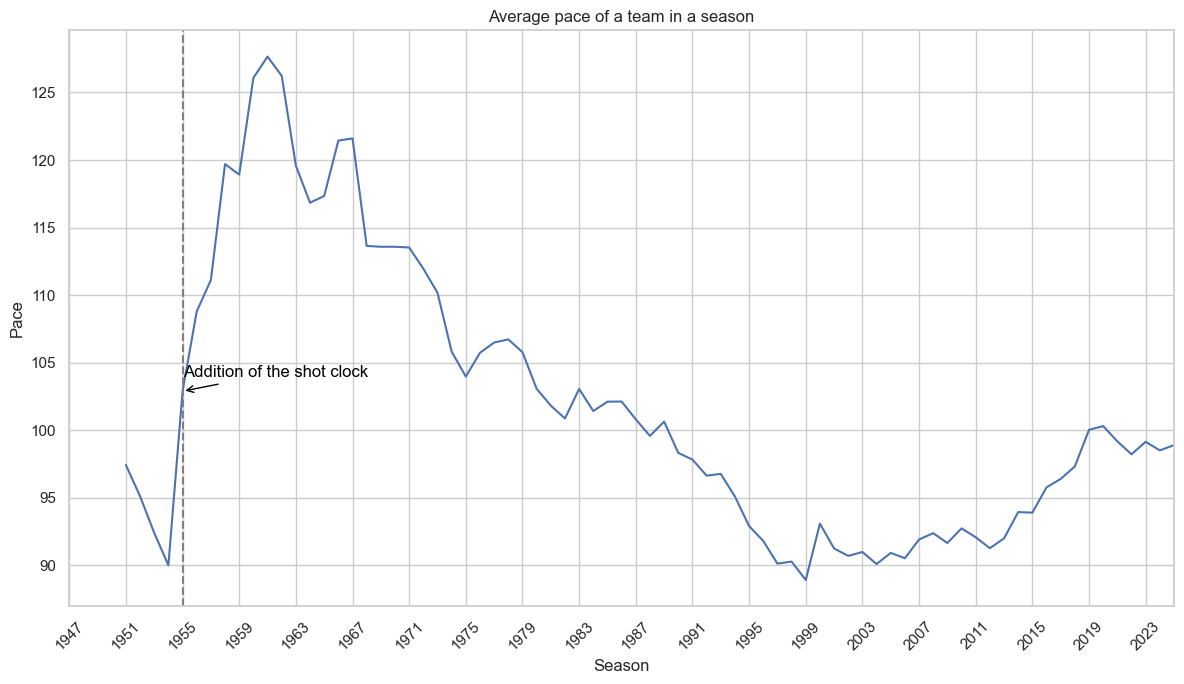

In [31]:
pace_season = team_summaries.groupby("season")["pace"].mean()

sns.set_theme(style="whitegrid")
palette = sns.color_palette("mako", n_colors=2)

plt.figure(figsize=(12,7))
sns.lineplot(pace_season)
plt.title("Average pace of a team in a season")
plt.xlabel("Season")
plt.ylabel("Pace")
plt.xlim(team_summaries["season"].min(), team_summaries["season"].max())
plt.xticks(range(team_summaries["season"].min(), team_summaries["season"].max() + 1, 4), rotation=45)


plt.axvline(x=1955, color='grey', linestyle='--')
plt.annotate('Addition of the shot clock', xy=(1955, pace_season[1955]), xytext=(0, 10),
             textcoords="offset points", arrowprops=dict(arrowstyle="->", color="black"), color="black")

plt.tight_layout()
plt.show()

The first major change in the NBA was the addition of the shot clock in 1955, after some teams started to stall the game to protect their lead. The shot clock forced teams to shoot the ball within 24 seconds, which increased the pace of the game and the number of possessions for a team.

### 4.2) Changes in ball handling and dribbling <a id="4.2"></a>

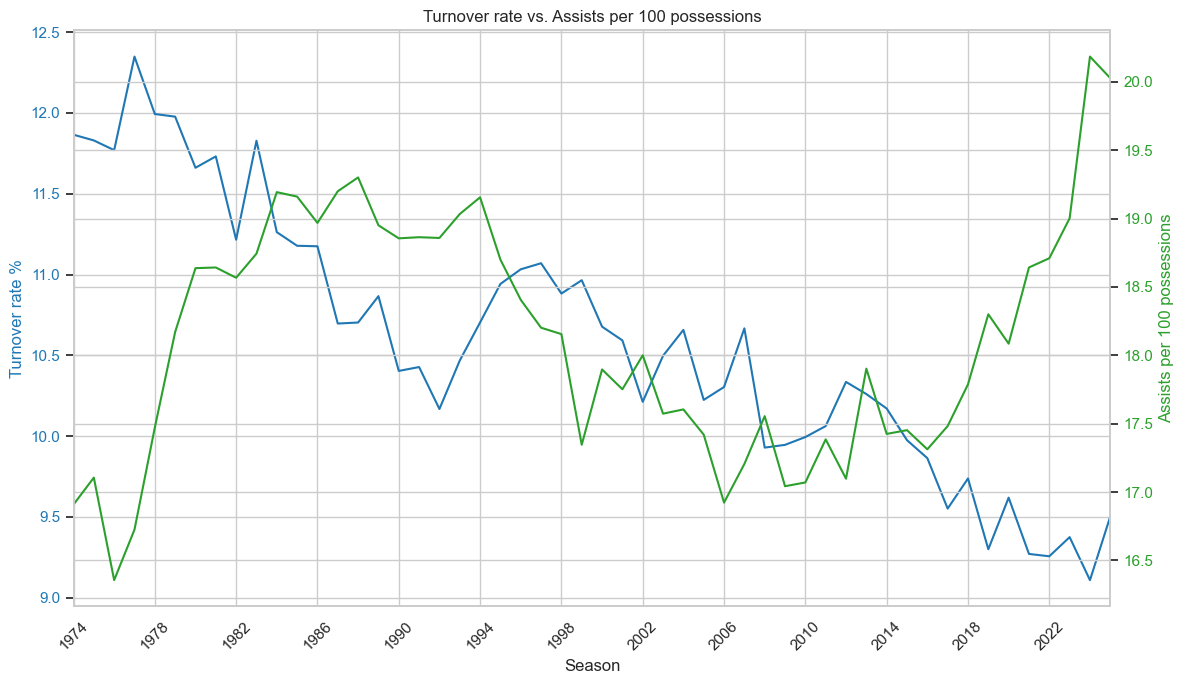

In [32]:
turnover_rate = team_summaries.groupby("season")["tov_percent"].mean() * 0.75

ast_per_75 = team_per_100_possessions.groupby("season")["ast_per_100_poss"].mean() * 0.75

fig, ax1 = plt.subplots(figsize=(12,7))

plt.title('Turnover rate vs. Assists per 100 possessions')

color = 'tab:blue'
ax1.set_xlabel('Season')
ax1.set_ylabel('Turnover rate %', color=color)
ax1.plot(turnover_rate, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax1.set_xticks(range(team_per_100_possessions["season"].min(), team_per_100_possessions["season"].max() + 1, 4))
ax1.set_xticklabels(ax1.get_xticks(), rotation=45)
ax1.set_xlim(team_per_100_possessions["season"].min(), team_per_100_possessions["season"].max())


ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Assists per 100 possessions', color=color)
ax2.plot(ast_per_75, color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()
plt.show()

Another change is how ball handling and travelling has been officiated. In the early days rules where more strictly enforced, letting players only dribble with their hand on top of the ball, meaning they couldn't let the ball hand and rest in the hand. The same happened with travelling, where players were held to two strict steps.

### 4.3) Game becoming softer <a id="4.3"></a>

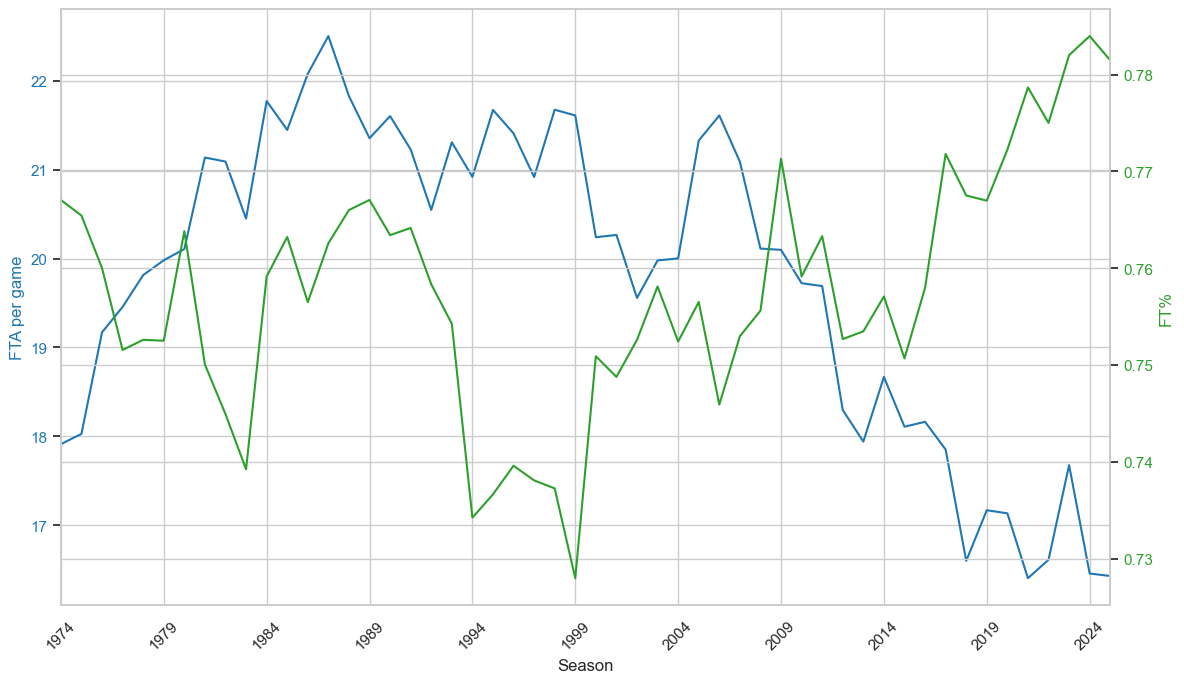

In [33]:
fta_per_75_poss = team_per_100_possessions.groupby("season")["fta_per_100_poss"].mean() * 0.75

ft_percent = team_per_100_possessions.groupby("season")["ft_percent"].mean()

fig, ax1 = plt.subplots(figsize=(12,7))
    
color = 'tab:blue'
ax1.set_xlabel('Season')
ax1.set_ylabel('FTA per game', color=color)
ax1.plot(fta_per_75_poss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('FT%', color=color)
ax2.plot(ft_percent, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_xlim(team_per_100_possessions["season"].min(), team_per_100_possessions["season"].max())
ax1.set_xticks(range(team_per_100_possessions["season"].min(), team_per_100_possessions["season"].max() + 1, 5))
ax1.set_xticklabels(ax1.get_xticks(), rotation=45)


fig.tight_layout()

Some NBA fans talk about the game being softer than it use to be, that there is too much fouls called, players are flopping and exploiting the rulebook to their advantage. However, when we look at the stats, the number of free throws per 75 has decreased since the 80s and 90s, while average free throw percentage has been slightly increasing. All this is probably due to the new spaced out game where players are shooting more instead of driving to the basket. So we can't really say that officiating fouls is the reason for the inflation.

### 4.4) Changes in defensive rules 

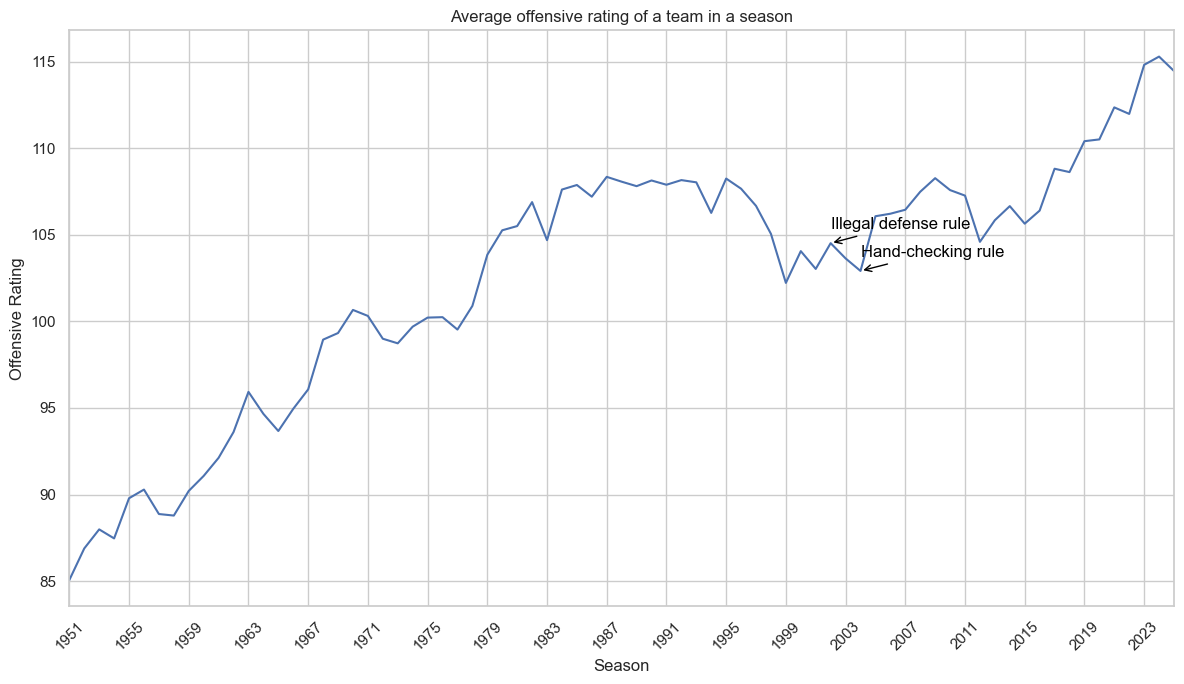

In [34]:
ortg = team_summaries.groupby("season")["o_rtg"].mean()

sns.set_theme(style="whitegrid")
palette = sns.color_palette("mako", n_colors=2)

plt.figure(figsize=(12,7))
sns.lineplot(ortg)
plt.title("Average offensive rating of a team in a season")
plt.xlabel("Season")
plt.ylabel("Offensive Rating")
plt.xlim(team_summaries[team_summaries["o_rtg"].notnull()]["season"].min(), team_summaries["season"].max())
plt.xticks(range(team_summaries[team_summaries["o_rtg"].notnull()]["season"].min(),team_summaries["season"].max(), 4 ), rotation=45)

plt.annotate('Hand-checking rule', xy=(2004, ortg[2004]), xytext=(0, 10),
             textcoords="offset points", arrowprops=dict(arrowstyle="->", color="black"), color="black")
plt.annotate('Illegal defense rule', xy=(2002, ortg[2002]), xytext=(0, 10),
             textcoords="offset points", arrowprops=dict(arrowstyle="->", color="black"), color="black")

plt.tight_layout()
plt.show()


In the 2002 season NBA added the illegal defense rule, which meant the players couldn't stay in the paint for more than 3 seconds without actively guarding a player. It prevented big man from camping underneath the basket, which opened up driving lanes to the basket. In 2004 NBA added the hand-checking rule, which meant that defenders couldn't use their hands to impede the progress of the offensive player. This also made it easier for guards to drive to the basket and create for their teammates.

### 4.5) Larger talent pool <a id="4.5"></a>

In [35]:
max_season = awards["season"].max()

mvps_last_5_years = awards[(awards["award"] == "nba mvp") & (awards["season"] > max_season - 5)].groupby("season")

for year, group in mvps_last_5_years:
    print(f"Year: {year}")
    print(group[["player", "share"]].sort_values("share", ascending=False).head(5))

Year: 2020
                    player  share
289  Giannis Antetokounmpo  0.952
290           LeBron James  0.746
291           James Harden  0.363
292            Luka Dončić  0.198
293          Kawhi Leonard  0.166
Year: 2021
                    player  share
228           Nikola Jokić  0.961
229            Joel Embiid  0.580
230          Stephen Curry  0.449
231  Giannis Antetokounmpo  0.345
232             Chris Paul  0.138
Year: 2022
                    player  share
160           Nikola Jokić  0.875
161            Joel Embiid  0.706
162  Giannis Antetokounmpo  0.595
163           Devin Booker  0.216
164            Luka Dončić  0.146
Year: 2023
                      player  share
108              Joel Embiid  0.915
109             Nikola Jokić  0.674
110    Giannis Antetokounmpo  0.606
111             Jayson Tatum  0.280
112  Shai Gilgeous-Alexander  0.046
Year: 2024
                     player  share
42             Nikola Jokić  0.935
43  Shai Gilgeous-Alexander  0.646
44          

In the last 5 years NBA award has been won by players from 5 different countries, which shows how the talent pool has expanded over the years. This is probably due to the NBA becoming more global, with players from all over the world coming to the league. This has also caused the game to evolve, as players from different countries bring different styles of play to the league.

### 4.6) Evolution of the three point shot <a id="4.6"></a>

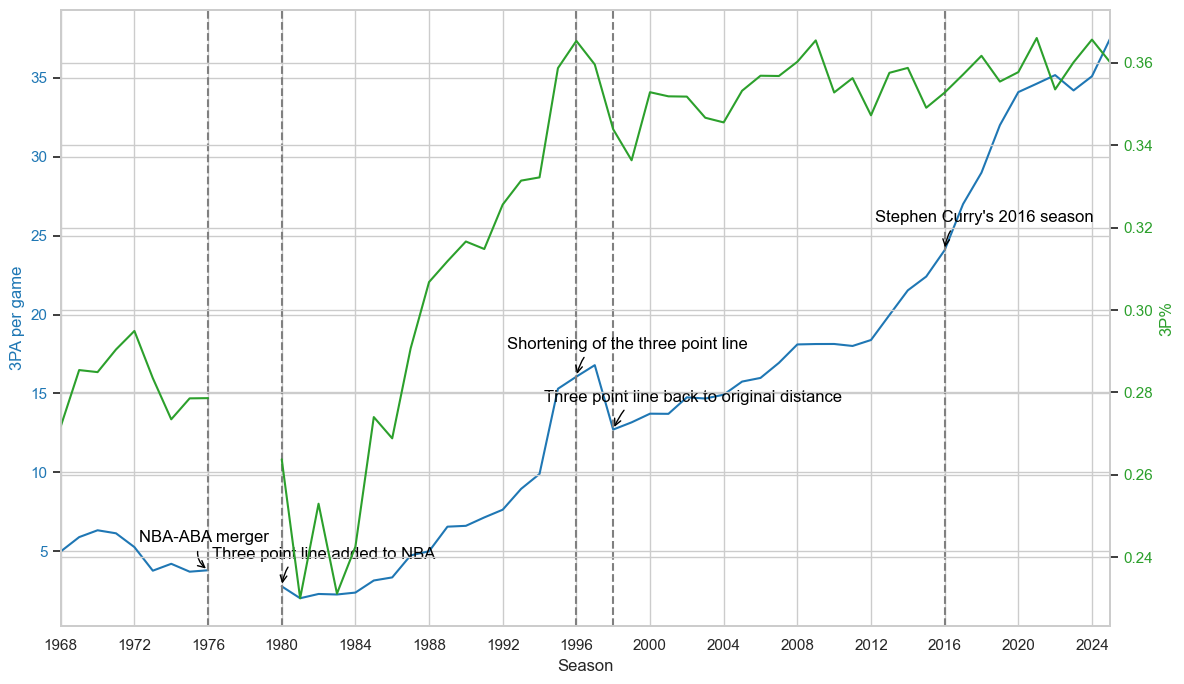

In [36]:
x3pa_per_game = team_per_game.groupby("season")["x3pa_per_game"].mean()
x3p_percent = team_per_game.groupby("season")["x3p_percent"].mean()

fig, ax1 = plt.subplots(figsize=(12, 7))

color = 'tab:blue'
ax1.set_xlabel('Season')
ax1.set_ylabel('3PA per game', color=color)
ax1.plot(team_per_game.groupby("season")["x3pa_per_game"].mean(), color=color)
ax1.tick_params(axis='y', labelcolor=color)

historical_events = {
    1976: ('NBA-ABA merger', team_per_game[team_per_game["season"] == 1976]["x3pa_per_game"].mean()),
    1980: ('Three point line added to NBA', team_per_game[team_per_game["season"] == 1980]["x3pa_per_game"].mean()),
    1996: ('Shortening of the three point line', team_per_game[team_per_game["season"] == 1996]["x3pa_per_game"].mean()),
    1998: ('Three point line back to original distance', team_per_game[team_per_game["season"] == 1998]["x3pa_per_game"].mean()),
    2016: ("Stephen Curry's 2016 season", team_per_game[team_per_game["season"] == 2016]["x3pa_per_game"].mean())
}

for year, (label, height) in historical_events.items():
    ax1.axvline(x=year, color='grey', linestyle='--')
    ax1.annotate(label, xy=(year, height), xytext=(-50, 20), 
                 textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.5", color="black"), color="black")

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('3P%', color=color)
ax2.plot(team_per_game.groupby("season")["x3p_percent"].mean(), color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_xlim(1968, team_per_game['season'].max())
ax1.set_xticks(range(1968, team_per_game['season'].max() + 1, 4))

fig.tight_layout()
plt.show()

The three point shot has first been introduced to pro leagues in 1961 by the ABL, which only lasted one full season. Then the ABA introduced the three point shot in 1967, which they used alongside slam dunk as a marketing tool to compete with the NBA. It lasted until the ABA-NBA merger in 1976. Finally, in 1980 NBA introduced the three point line we know today and the rest is history. The 3pt field goal percentage hasn't really changed since the mid 90s, where we saw a big spike from the previous years due to the league shortening the distance for three years hoping to encourage more players to shoot the three.

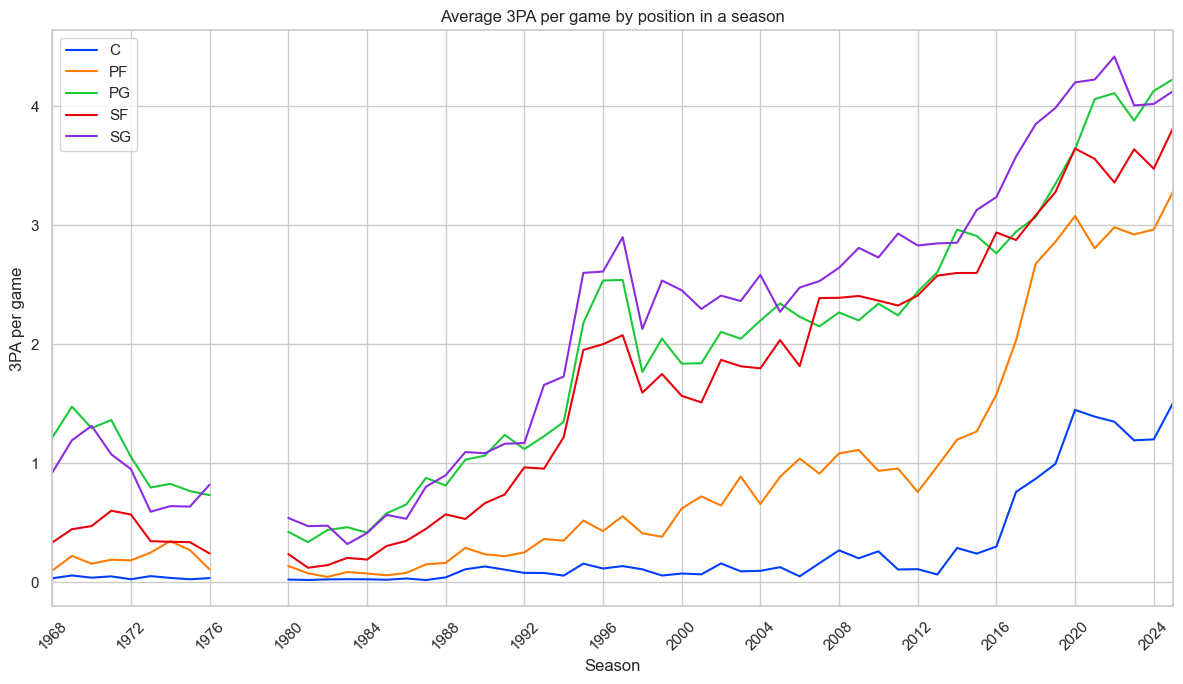

In [39]:
x3pt_by_pos_year = player_better_stats.groupby(["season", "pos"])["x3pa_per_game"].mean().reset_index()

data_pre_1976 = x3pt_by_pos_year[x3pt_by_pos_year['season'] <= 1976]
data_post_1980 = x3pt_by_pos_year[x3pt_by_pos_year['season'] >= 1980]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,7))

sns.lineplot(x="season", y="x3pa_per_game", hue="pos", data=data_pre_1976, palette="bright")

sns.lineplot(x="season", y="x3pa_per_game", hue="pos", data=data_post_1980, palette="bright")

plt.title("Average 3PA per game by position in a season")
plt.xlabel("Season")
plt.ylabel("3PA per game")
current_season_max = x3pt_by_pos_year['season'].max()
plt.xlim(1968, current_season_max)
plt.xticks(range(1968, current_season_max + 1, 4), rotation=45)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='')

plt.tight_layout()
plt.show()

Let's look at how the three point shooting has evolved by position over the years. We see that the point guards have always been the most willing to shoot the three, while the centers have been the least willing to shoot the three. However, in the last 10 years we see that the centers have started to shoot more threes, while the shooting guards have started to shoot fewer threes. This is probably due to the league changing to a more spaced out game, where the centers are encouraged to shoot the three, while the shooting guards are encouraged to drive to the basket.

# 5) Conclusion <a id="5"></a>
There are many factors leading to the inflation of the stats in the modern era, from rule changes to tactical changes to cultural changes. The game has evolved over the years, with players becoming more skilled and the game becoming more spaced out. The three point shot has become a major part of the game, with players shooting more threes than ever before. The game has also become more global, with players from all over the world coming to the league. This has caused the game to change, as players from different countries bring different styles of play to the league. The league has also implemented rules that made scoring easier. All these factors have led to the inflation of the stats in the modern era, with players putting up numbers that would have been unheard of in the past.